# Coordle Backend

In [39]:
import pandas as pd 
import numpy as np
from importlib import reload
import nltk
import spacy
from coordle.utils import clean_text
from nltk.corpus import stopwords as _stopwords
from tqdm import tqdm
from collections import deque
from copy import deepcopy
from collections.abc import Iterable
from typing import Union
from pprint import pprint
from itertools import chain
import pymongo


import os
import json
import re 
from string import punctuation as PUNCTUATION
from nltk.corpus import stopwords as _stopwords
from gensim.models import Word2Vec
from os.path import join as join_path
from gensim.models.callbacks import CallbackAny2Vec

In [ ]:
df = pd.read_csv('data/cord-19-data.csv')

In [ ]:
class EpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''
class DocEpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''

In [ ]:
# Load the last trained model
model = Word2Vec.load(join_path('data', 'cord-19-w2v.model'))
word_to_int = {word:i for i, word in enumerate(model.wv.index2word)}
int_to_word = np.array(model.wv.index2word)

In [ ]:
import coordle
reload(coordle)
from coordle.backend import (CordDoc, Index, RecursiveDescentParser, 
                             QueryAppenderIndex)

ai_index = QueryAppenderIndex(model.wv.most_similar, n_similars=1)
ai_index.build_from_df(
    df[:16],
    'cord_uid',
    'title',
    'body_text', 
    verbose=True, 
    use_multiprocessing=True,
    workers=-1
)

In [ ]:
import coordle
reload(coordle)
from coordle.backend import CordDoc, Index, RecursiveDescentParser, QueryAppenderIndex

docs, scores, errmsgs = ai_index.search('virus')

n = 69
if errmsgs:
    print(errmsgs)
else:
    for doc, score in zip(docs, scores):
        print(f'{doc.uid}  {str(doc.title)[:70]:<70}  {score:.4f}')


In [ ]:
ai_index.docmap['grace']

# Mongo

In [16]:
import coordle
reload(coordle)
from coordle.backend import (CordDoc, Index, RecursiveDescentParser, QueryAppenderIndex)

# ram_index = Index()
ram_index = QueryAppenderIndex(model.wv.most_similar, 1)
ram_index.build_from_df(
    df[:128],
    'cord_uid',
    'title',
    'body_text', 
    verbose=True, 
    use_multiprocessing=True,
    workers=-1
)

Text cleaning initilized on 16 workers


Adding to index: 100%|██████████| 128/128 [00:00<00:00, 412.52it/s]


In [17]:
model.wv.most_similar('corona')

[('coronavirus', 0.5875847339630127),
 ('coronovirus', 0.4919204115867615),
 ('sialodacryoadenitis', 0.49028030037879944),
 ('coronalike', 0.48141905665397644),
 ('hanta', 0.46863046288490295),
 ('rota', 0.4572141170501709),
 ('henipa', 0.4544263780117035),
 ('calicilike', 0.4494871497154236),
 ('astro', 0.4480387568473816),
 ('akabane', 0.44490841031074524)]

In [19]:
import coordle_mongobackend as cm
reload(cm)

# mongoindex = cm.Index('coordle')
mongoindex = cm.AI_Index('coordle-lite', model.wv.most_similar, 1)
mongoindex.drop_old_collections()
mongoindex.build_from_df(df[:128], 'cord_uid', 'title', 'body_text', 
                         use_multiprocessing=True, workers=-1, verbose=True)

Text cleaning initilized on 16 workers


Initialized database index with size 128
Inserting wordmap to database: 100%|██████████| 21296/21296 [00:00<00:00, 61771.33it/s]


In [20]:
docs, scores, errmsgs = ram_index.search('virus')

if errmsgs:
    print(errmsgs)
else:
    for doc, score in zip(docs, scores):
        print(f'{doc.uid}   {score:.4f}')

1wswi7us   4.3461
rxbcuseq   4.0896
mxyxwkhx   3.4652
yy96yeu9   2.9657
v95fzp8n   2.8680
4u2re1cu   2.7693
pyam9yn3   2.6375
0fitbwuv   2.5710
jzj8q25c   2.3761
zowp10ts   2.3610
efrv5nvf   2.3361
4k8f7ou1   2.2633
covwyddp   2.1964
m9rg6d3w   2.1085
eqiokrub   2.0828
zc491h8v   2.0400
i948aq4b   1.9596
402ls2aq   1.9440
qj4dh6rg   1.9178
e6e5nvn9   1.8525
jlhykfbf   1.8403
4mnaicki   1.7976
rrhh2alf   1.7358
04cuk2cn   1.7270
kqithgfo   1.6879
jh9e85c0   1.6357
vblgotjn   1.6220
xqhn0vbp   1.5734
azkamnpa   1.5372
1ke7i2wr   1.5274
0brhn8oc   1.3996
qzm9wgde   1.3740
qg0fsliy   1.3605
0gmtnkbh   1.3135
5gsbtfag   1.2184
t20z4mtt   1.1428
7ots8npg   1.1306
p7um7o87   1.1234
dgnddq80   1.1137
fpj5urao   0.9534
1i36lsj2   0.9528
lwla5ugt   0.9432
5s6acr7m   0.9225
pwsvhitd   0.9024
ln8ddyuj   0.8912
ng4rrdte   0.8897
jz61fxpn   0.8740
xtg0e142   0.8406
ic4d9dhk   0.8037
gi6uaa83   0.7531
le0ogx1s   0.6637
xv0esvos   0.6512
g2f151oc   0.6384
9k55f9o6   0.5409
mcfmxqp2   0.5335
89xnnvuv  

In [21]:
%%time
docs, scores, errmsgs = mongoindex.search('virus')

if errmsgs:
    print(errmsgs)
else:
    for doc, score in zip(docs, scores):
        print(f'{doc}   {score:.4f}')

deque(['virus', 'OR', 'viruses'])
1wswi7us   6.9742
v95fzp8n   4.7759
rxbcuseq   3.9033
efrv5nvf   3.5226
jlhykfbf   3.1859
yy96yeu9   2.7622
azkamnpa   2.6476
1ke7i2wr   2.5464
0fitbwuv   2.4944
4k8f7ou1   2.3703
04cuk2cn   2.3648
jzj8q25c   2.3393
t20z4mtt   1.9912
dgnddq80   1.9810
eqiokrub   1.9740
xqhn0vbp   1.9176
pyam9yn3   1.8420
0brhn8oc   1.8389
4mnaicki   1.8203
fpj5urao   1.7773
jh9e85c0   1.6942
kqithgfo   1.6882
zowp10ts   1.6425
mxyxwkhx   1.6360
covwyddp   1.6148
zc491h8v   1.5761
1i36lsj2   1.5643
402ls2aq   1.4608
qj4dh6rg   1.4099
5s6acr7m   1.2821
4u2re1cu   1.2680
vblgotjn   1.2619
lwla5ugt   1.2553
le0ogx1s   1.2372
xtg0e142   1.1682
rrhh2alf   1.1382
e6e5nvn9   1.0813
qzm9wgde   1.0534
9k55f9o6   1.0082
5gsbtfag   0.9806
89xnnvuv   0.9740
ln8ddyuj   0.9677
0qaoam29   0.9024
p7um7o87   0.8935
m9rg6d3w   0.8529
qg0fsliy   0.7677
8zwsi4nk   0.7286
0gmtnkbh   0.7226
pqzwk6rj   0.6860
t40ybhgb   0.6422
0svscbpu   0.6012
mcfmxqp2   0.5998
ckby80vf   0.5846
ofx0hvvs   0

In [21]:
wordmap = {word:[doc.uid for doc in docs] for word, docs in ai_index.docmap.items() if len(word) < 100}

In [24]:
client = pymongo.MongoClient()
db_test = client['coordle']
db_test.wordcounts.count_documents({})

36565

In [35]:
vals, counts = np.unique(['a','a','a','b','b','b','b','c'], return_counts=True)
print(vals)
print(counts)

['a' 'b' 'c']
[3 4 1]


In [38]:
thing = pd.value_counts(['a','a','a','b','b','b','b','c'])
print(thing.index.values)
print(thing.values)

['b' 'a' 'c']
[4 3 1]


<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<center><h2> Junkyard </h2></center>

In [ ]:
raise ValueError

Creating sets from dicts is faster than from lists

In [26]:
from time import time 
from matplotlib import pyplot as plt 
import numpy as np

dict_time = []
list_time = []
ratios = []

xrange = np.arange(1000,1000000,1000)
B = set(list(range(100000)))

for j in xrange:
    a = list(range(j))

    t0=time()
    A = set(a)
    A | B
    t1_list = time()-t0
    list_time.append(t1_list)
    
    a = {i:None for i in range(j)}
    
    t0=time()
#     A = set(a)
    a.keys() | B
    t1_dict = time()-t0
    dict_time.append(t1_dict)

    ratios.append(t1_list/t1_dict)

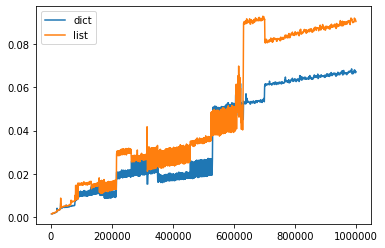

In [27]:
plt.plot(xrange[1:], dict_time[1:], label='dict')
plt.plot(xrange[1:], list_time[1:], label='list')
plt.legend()
plt.show()

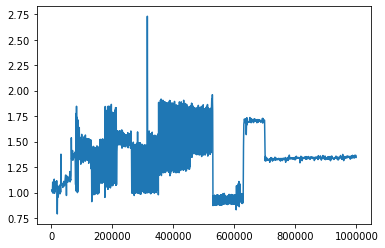

In [28]:
plt.plot(xrange[1:], ratios[1:])
plt.show()

In [ ]:
import coordle_backend
reload(coordle_backend)
from coordle_backend import CordDoc, Index2, RecursiveDescentParser, AI_Index2
Index = Index2

queries = [
    'retarded!!!',
#     '(',
#     ')',
    'retarded (white AND (woman NOT man))',
    'retarded (white AND white) man',
#     'retarded OR white OR woman',
#     'retarded white AND woman',
#     'retarded OR white NOT woman',
#     'retarded (white NOT woman)',
#     'retarded (white NOT woman)',
#     'OR retarded AND white woman',
#     'retarded AND AND white NOT woman',
#     'retarded (white NOT woman) AND',
#     ')retarded ((white NOT woman) AND',
#     'retarded ((white NOT woman)',
#     'AND retarded)) ((white NOT woman) NOT',
]

rdp = RecursiveDescentParser(index.docmap)
for query in queries:
    errmsgs = []
    tokens = rdp.get_logical_querytokens(query)
    pass_ = rdp.assert_query(tokens, errmsgs)
    
#     print(tokens)
    print(rdp.parenthesis_handler(tokens))
#     print(errmsgs)
    print(pass_)
    print()
    